In [1]:
# Author: Brandon Botzer
# Date: 1/22/2024
# Class: Penn State - AI 879

Q1:
The Question origionally read:

Modify the code in Section 6.1 to perform more pyramid transformation iterations. For example, you can use a smaller template or increase the size of the image. Replace the impyramid function with down-sample function with a smaller factor (for example sub-sample to 0.8). Show the result and discuss.

This is primarily what I have done within this notebook.

Later, this question was later updated to read:


Modify the code in Section 6.1: by following instructions and discuss the result/insights from result.

1. increase input image size as 150%.

2. reduce template size as 50%

3. increase number of iterations to 5 times

4. replacing impyramid with imresize down-sampling of factor 0.8

I included some pieces at the end regarding the image correlation for this.



In [2]:
# Imports for functions

# The scikit-image package provides a wide variety of filter applications
#  which reduce the need to write out the corr / conv matricies

import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

cv.__version__, ski.__version__



('4.8.1', '0.22.0')

In [3]:
def pyramid_plotter(pyr_list):
    # Plot the output in a clever way to show the pyramid:
    #  From skimage example:  https://scikit-image.org/docs/stable/auto_examples/transform/plot_pyramid.html#sphx-glr-auto-examples-transform-plot-pyramid-py

    rows, cols, ch = pyr_list[0].shape

    # determine the total number of rows and columns for the composite
    #  Find the total number of rows of either the origional image or the pyramid rows summed
    composite_rows = max(rows, sum(p.shape[0] for p in pyr_list[1:]))
    #  Find the total number of columns by adding the origional and the first pyramid layer together
    #    all subsequent pyramid images will exist within this
    composite_cols = cols + pyr_list[1].shape[1]

    # Set the large grid to contain all of the images
    composite_image = np.zeros((composite_rows, composite_cols, 3),
                            dtype=np.double)

    # Store the original image to the left of the composite image
    composite_image[:rows, :cols, :] = pyr_list[0]

    # stack all downsampled images in a column to the right of the original

    i_row = 0 # Start the row count from the zero row (the top)
    # Loop for each layer in the pyramid
    for p in pyr_list[1:]:
        # Get the number of rows and columns for the current pyramid layer
        n_rows, n_cols = p.shape[:2]
        # From the last row position, add the current pyramid layer image
        composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
        # move the row count down for the next image
        i_row += n_rows

    # Plot the composite image
    fig, ax = plt.subplots()
    ax.imshow(composite_image)
    plt.show()

In [4]:
# Read in values

im = ski.io.imread('L06 sunflower.png')
im = ski.util.img_as_float64(im)
tplt = ski.io.imread('L06 sunflower Template.png')

In [5]:
# Get the shape of the origional image
rows, cols, ch = im.shape
rows, cols, ch

(594, 960, 3)

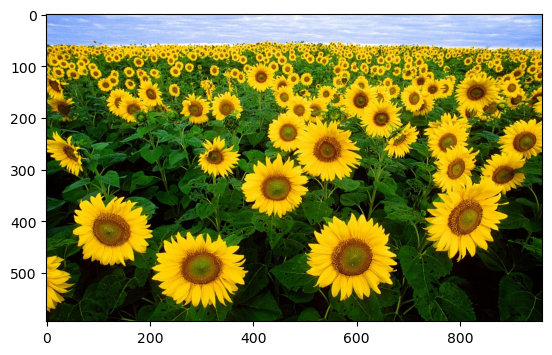

In [6]:
plt.imshow(im)

# Gaussian Pyramid

In [7]:
# Use the pyramid generator to create a recursive image pyramid (assign to tuple to run the generator)
pyramid_gauss = list(ski.transform.pyramid_gaussian(im, downscale=2, channel_axis=-1)) # uses 'bilinear' by default

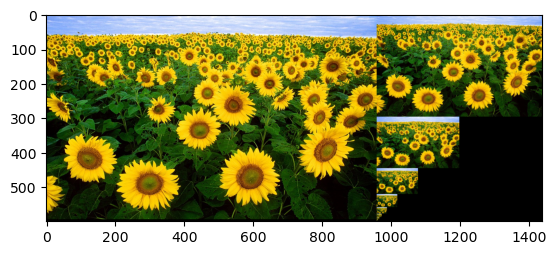

In [8]:
pyramid_plotter(pyramid_gauss)

# Laplacian Pyramid

In [9]:
# Use the pyramid generator to create a recursive image pyramid (assign to tuple to run the generator)
pyramid_laplace = list(ski.transform.pyramid_laplacian(im, downscale=2, channel_axis=-1)) # uses 'bilienar' by default


In [10]:
# Currently the last image in the Laplacian pyramid is a subtraction layer.
# Per the code in 6.1, Figure 6.6, the last layer of the Laplacian is the same as the Gaussian pyramid.
# Substitue back in the gaussian's last layer at the last laplacian layer.

# For this, it is effectivly changing a dark black pixel to a mustard yellow
pyramid_laplace[-1] = pyramid_gauss[-1]

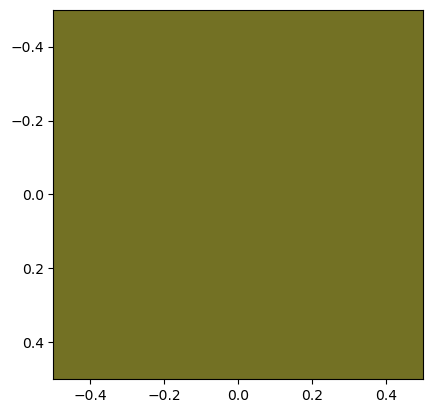

In [11]:
#  The mustard yellow pixel from the guassian now in the laplacian pyramid
plt.imshow(pyramid_laplace[-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


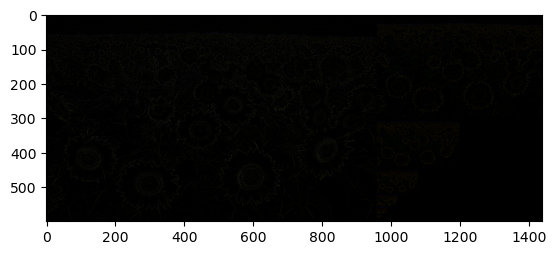

In [12]:
pyramid_plotter(pyramid_laplace)

Note that this image is largely black as it is the difference bwetween the origional, unscaled image and the smoothed version.  When reconstructing an image, the layers of the laplacian are added back onto the resized 

# Image Reconstruction

In [13]:
def round_pix_vals(pyramid, decimals_kept=3):
    '''Round the floating pixel values in an image to one decimal point.
    This is being used primarily to compress values for a Laplacian pyramid.
    Code based on and modified from AI879 lesson 6.1 Figure 6.6.

    Args:
        pyramid:  The pyramid of the image

        decimals_kept: the number of decimal places to keep

    Returns:
        pyr_quant: The floating images for the pyramid rounded to one decimal'''

    # List to hold the quantitized pyramid values
    pyr_quant = []

    # Loop over each level of the pyramid
    for py in pyramid:
        # Round the level to the number of decimal places
        rounded = np.round(py, decimals_kept)
        # Append the value to the storage list
        pyr_quant.append(rounded)

    return pyr_quant

In [14]:
# Round the Laplacian pyramid floating point values to reduce space
pyramid_laplace_quant = round_pix_vals(pyramid_laplace, decimals_kept=3)

In [15]:
def LaplacianReconstruction(lap_pyr):
    '''Reconstruct the Laplacian image back to the origional image.
    Code based on and modified from AI879 lesson 6.1.

    Args:
        lap_pyr: The Laplacian pyramid used for reconstruction

    Returns:
        out_via_lap: The reconstructed image array
    '''

    # Start with the last image in the Laplacian pyramid for reconstruction
    out_via_lap = lap_pyr[-1]

    # Loop in reverse order all of the images in the Laplacian pyramid
    for lpy in reversed(lap_pyr):

        # Upscale through pyramid expansion to current smallest level of the pyramid
        out_via_lap = ski.transform.pyramid_expand(out_via_lap, upscale=2, order=1, channel_axis=-1) # order of 1 corresponds to 'bilinear' per: https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.warp

        M, N, ch = lpy.shape

        out_via_lap = out_via_lap[:M, :N, :] + lpy


    return out_via_lap



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


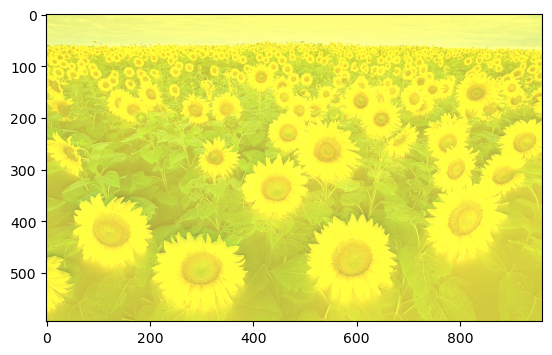

In [16]:
# Reconstruct the Laplacian Pyramid
im_via_lap = LaplacianReconstruction(pyramid_laplace_quant)
plt.imshow(im_via_lap)

Notice that the image has been reconstructed but with a near constant yellow haze across it.  This may be an artifact kept from the 1x1 mustart yellow image at the begining but I am not certain of this.  Any information on why this may be happening would be helpful.

Taking a finer layer, instead of the most coarse, would likely have resulted in less of a yellow haze.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


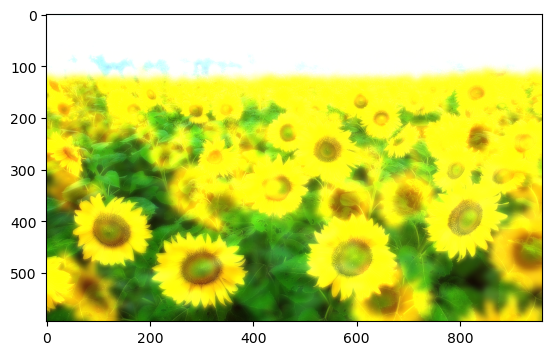

In [17]:
# Take only the first few layers of the gaussian and laplacian pyramids
slim_pyr_gauss = pyramid_gauss[:3]
slim_pyr_lap = pyramid_laplace[:3]

# Append the 'last' layer of the gaussian to the Laplacian per code in 6.1 FIgure 6.6
slim_pyr_lap[-1] = slim_pyr_gauss[-1]

# Reduce the pixel values
slim_pyr_lap_reduced = round_pix_vals(slim_pyr_lap, 3)

# Reconstruct the image
im_via_slim_lap = LaplacianReconstruction(slim_pyr_lap_reduced)

# Output the reconstruction
plt.imshow(im_via_slim_lap)

We see here less of the global yellow haze but we have lost some of the features by not using the full Laplacian pyramid.  We also see some ghost sunflowers here which we did not when using the full pyramid reconstruction.

# Subsampling at 0.8

Replace the impyramid function with down-sample function with a smaller factor (for example sub-sample to 0.8). Show the result and discuss.

## Create a Gaussian Pyramid at the subsample rate

In [18]:

scale_factor = 0.8 # This will take less out during each down sample.  Instead of reducing by 50%, it will reduce by 20%

In [19]:
# I'll run the rescalling a total of 27 times; This is the last time a change occurs in the rescaling.
# Note to self, this can be done via recursion but I'm not going through that exercise right now...

scaled_list = []

# Rescale by the origional image
# Function to rescale (down-sample)
# anti-aliasing applies a gaussian filter before the down-scaleing; uses bilinear interpolation as per: https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.warp
scaled_im = ski.transform.rescale(im, scale=scale_factor, anti_aliasing=True, channel_axis=-1)
scaled_list.append(scaled_im) # store rescaled image

check = False
# Loop over the rescaled images
while check == False:

    # Get the old size of the image
    old_size = scaled_im.size
    # Rescale the image
    scaled_im = ski.transform.rescale(scaled_im, scale=scale_factor, anti_aliasing=True, channel_axis=-1)
    # Get the new size of the image
    new_size = scaled_im.size
    # Store the new image out
    scaled_list.append(scaled_im)
    # Check to see if the old and new match.  If so, the loop with end.
    check = (old_size == new_size)

# Remove the duplicated one at the end from the extra save in the loop.
# This was done over a break statement since I'd have to check the if statement each loop through.
scaled_list = scaled_list[:-1]

# Insert the origional image in at the zero index to match the formatting of the above gaussian pyramid
scaled_list.insert(0, ski.util.img_as_float64(im))  # Recast the image as a float to correspond to the other images for plotting

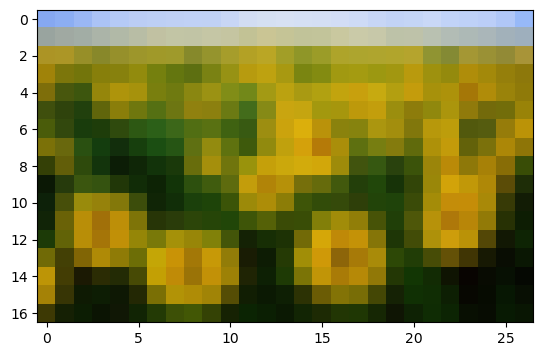

In [20]:
# Intermediate layer in the rescaling
plt.imshow(scaled_list[16])

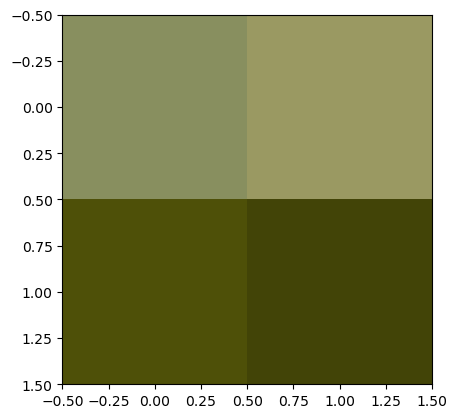

In [21]:
# Last layer in the rescaling
plt.imshow(scaled_list[-1])

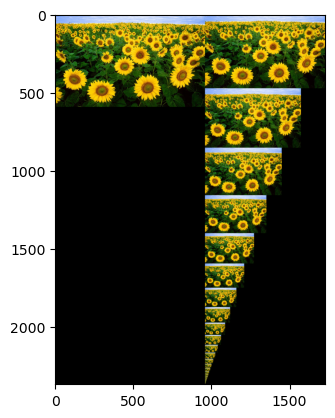

In [22]:
# This is the Gaussian Pyramid
pyramid_plotter(scaled_list)

## Create the Laplacian Pyramid at the subsample rate

In [23]:
def custom_Lap(pyramid):
    '''The Laplacian Pyramid function provided in section 6.1.
    Modified from work via Steve Eddins; Mathworks.

    Args:
        pyramid: The Gaussian Pyramid to be used to create the Laplacian Pyramid

    Returns:
        lap_pyr: The Laplacian Pyramid
    '''

    # Laplacian pyramid storage list
    lap_pyr = []

    # Loop for the elements in the gaussian pyramid
    for i in range(0, len(pyramid)-1):

        # Take the current Gaussian layer
        A = pyramid[i]
        # Take the next Gaussian layer and expand it upwards to be the same shape as 'A'
        B = ski.transform.pyramid_expand(pyramid[i+1], channel_axis=-1) # upscales by factor of 2 and uses bilinear interpolation
        # Get the shape of 'A' in which to do the subtraction on.
        M, N, _ = A.shape
        # Subtract the images and store them into the list
        lap_pyr.append(A - B[:M, :N, :])

    # The last layer of the Laplacian pyramid should be the same as the Gaussian pyramid
    lap_pyr[-1] = pyramid[-1]

    return lap_pyr

In [24]:
# Create the Laplacian pyramid
scaled_laplacian = custom_Lap(scaled_list)
# Compress the image
scaled_laplacian_quant = round_pix_vals(scaled_laplacian, decimals_kept=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


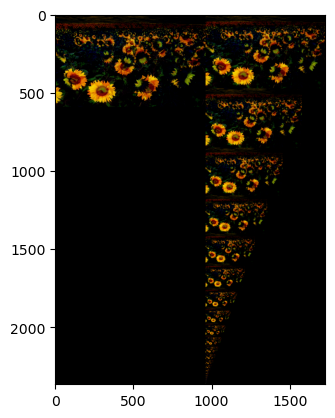

In [25]:
# Plot the Laplacian pyramid created from the custom function
pyramid_plotter(scaled_laplacian_quant)

I am surprised that this is not darker as the Laplacian pyramid from skimage returned... I wonder if the custom Laplacian is building different in some way than skimage's, or there is the possibility of my error somewhere here I do not see...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


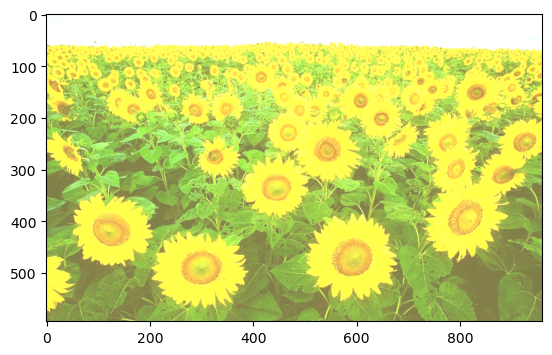

In [26]:
# Run the reconstruction from the Laplacian pyramid
scaled_reconstructed = LaplacianReconstruction(scaled_laplacian_quant)
plt.imshow(scaled_reconstructed)

Once again we see a haze on this reconstruction for unknown reasons.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


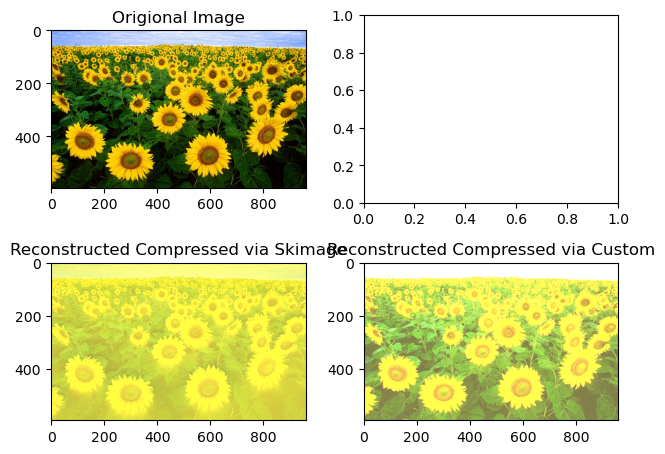

In [27]:
fig, ax = plt.subplots(2,2)
plt.tight_layout()


ax[0,0].set_title('Origional Image')
ax[0,0].imshow(im)

ax[0,1].set_title('')
# ax[0,1].imshow()

ax[1,0].set_title('Reconstructed Compressed via Skimage')
ax[1,0].imshow(im_via_lap)

ax[1,1].set_title('Reconstructed Compressed via Custom')
ax[1,1].imshow(scaled_reconstructed)

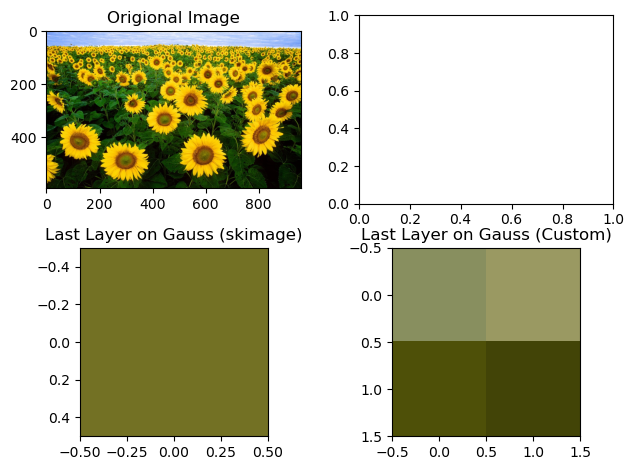

In [28]:
fig, ax = plt.subplots(2,2)
plt.tight_layout()


ax[0,0].set_title('Origional Image')
ax[0,0].imshow(im)

ax[0,1].set_title('')
# ax[0,1].imshow()

ax[1,0].set_title('Last Layer on Gauss (skimage)')
ax[1,0].imshow(pyramid_gauss[-1])

ax[1,1].set_title('Last Layer on Gauss (Custom)')
ax[1,1].imshow(scaled_list[-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


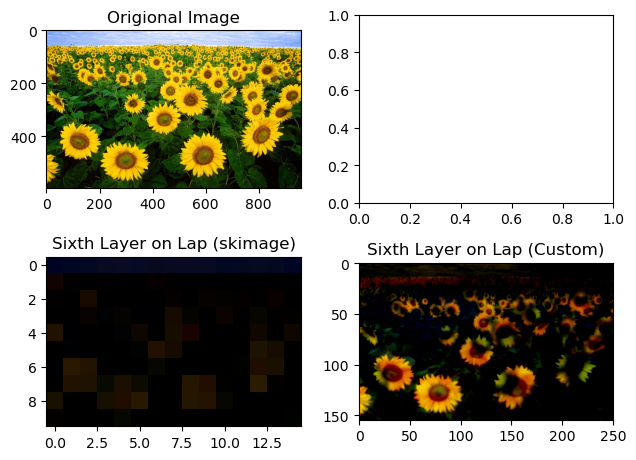

In [29]:
fig, ax = plt.subplots(2,2)
plt.tight_layout()


ax[0,0].set_title('Origional Image')
ax[0,0].imshow(im)

ax[0,1].set_title('')
# ax[0,1].imshow()

ax[1,0].set_title('Sixth Layer on Lap (skimage)')
ax[1,0].imshow(pyramid_laplace_quant[6])

ax[1,1].set_title('Sixth Layer on Lap (Custom)')
ax[1,1].imshow(scaled_laplacian_quant[6])

## Discussion

By sampling at a differet factor (0.8 instead of 0.5), the pyramids had many more levels to them.  As such, each individual level of the pyramid, more detail exists.  At the lowest level, the pyramid in the 0.8 case was not bound by a single cell color when rebuilding the image thus resulting in less of a mustard yellow haze.  I both cases, I was unable to fully reconstruct the origional image.  The haze is a large artifact that I was not expecting and I am uncertain as to what could be causing it.  My only guess I have at the moment is that having the last layer of the Laplacian pyramid be the same as the Gaussian pyramid's last layer may be causing something to occur here.  I am also uncertain as to why the custom Laplacian pyramid function I built is displaying at such brighter levels when compared to the skimage version.  Both are taking the difference (subtraction) of the two images so I'm a bit at a loss again...

For my own curriosity... can I use just some higher layers to remove the haze and still get solid features?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


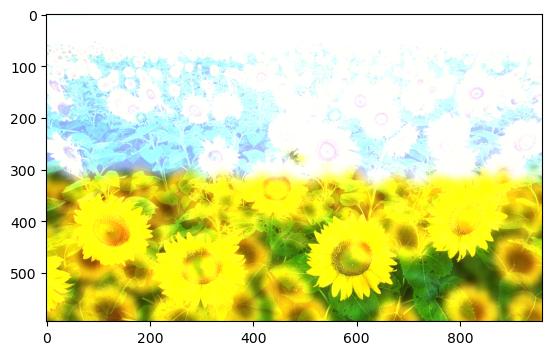

In [30]:
# Take only the first few layers of the gaussian and laplacian pyramids to see what happens.
slim_pyr_gauss = scaled_list[:3]
slim_pyr_lap = scaled_laplacian[:3]

# Append the 'last' layer of the gaussian to the Laplacian per code in 6.1 FIgure 6.6
slim_pyr_lap[-1] = slim_pyr_gauss[-1]

# Reduce the pixel values
slim_pyr_lap_reduced = round_pix_vals(slim_pyr_lap, 3)

# Reconstruct the image
im_via_slim_lap = LaplacianReconstruction(slim_pyr_lap_reduced)

# Output the reconstruction
plt.imshow(im_via_slim_lap)

No... no I can not.

# For Looking at the Image Correlation Peaks

In [31]:
# Rescale the flower image and template to 150% and 50% respectivly.
# Make them grayscale as in 6.1

gray_flowers = ski.color.rgb2gray(im)
gray_flowers_scaled = ski.transform.rescale(gray_flowers, scale = 1.5)

gray_template = ski.color.rgb2gray(tplt)
gray_template_scaled = ski.transform.rescale(gray_template, scale = 0.5)

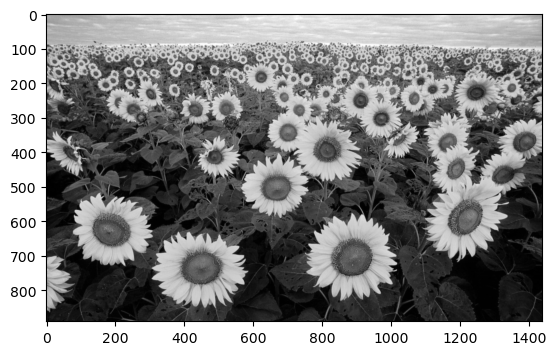

In [32]:
plt.imshow(gray_flowers_scaled, cmap='gray')

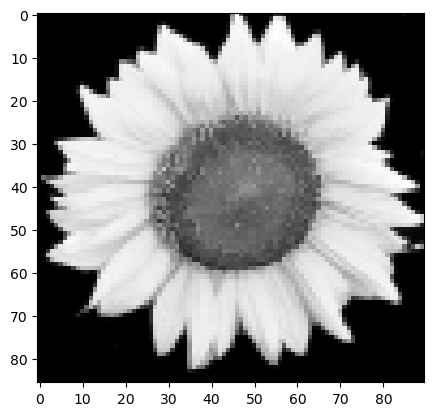

In [33]:
plt.imshow(gray_template_scaled, cmap='gray')

In [34]:
# The cross correlate for 2D arrays is found in scipy

import scipy as sci

from matplotlib.patches import Rectangle

In [35]:
# Run the cross correlation between the image and the template
corr = sci.signal.correlate2d(gray_flowers_scaled, gray_template_scaled)

# I found later that the skimage function to this may be ski.feature.match_template():
# https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_template.html#sphx-glr-auto-examples-features-detection-plot-template-py

In [36]:
# Display Correlation

y_ax = np.arange(0, 1529, 1)
x_ax = np.arange(0, 976, 1)
x,y = np.meshgrid(y_ax, x_ax)

z  = corr[y,x]


In [37]:
# Double checking the correlation 'image' shape
corr.shape

(976, 1529)

In [38]:
# maximum value of the correlation
z.max()

2778.4045209700253

In [39]:
# Minimum value of the correlation
z.min()

0.0

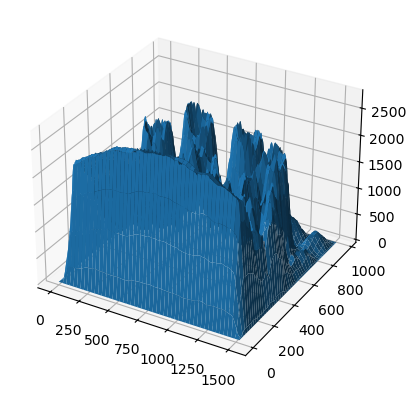

In [40]:
# Create a 3D plot the the correlation

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x, y, z)

# Unlike the example, we see many peaks here and a large wall at one end of the image.

[84] [763]
[85] [855]
[84] [772]
[84] [788]
[84] [780]
[84] [720]
[95] [931]
[94] [948]
[85] [955]
[100] [994]


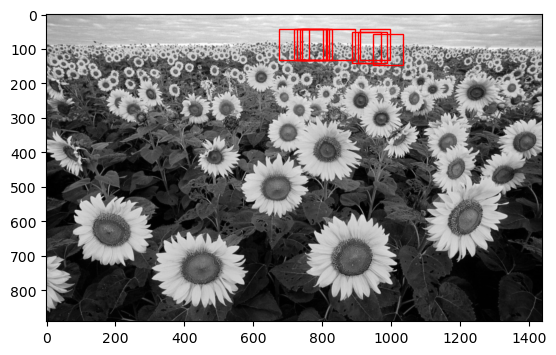

In [41]:
# Get the local maximal pixels for the correlation

# The values of the correlation go between 0 and 2778.  I'll take half of the max as being my threshold.  This is done in the peak_local_max function.

thresh = 0.5

# Finds all of the local maximums in the correlation at the threshold (0.5 * max(corr))
# Keeping just the 10 highest peak intensities
xy_coords = ski.feature.peak_local_max(image=corr, min_distance=5, threshold_rel=thresh, num_peaks=10)

# Plotting
fig, ax = plt.subplots()
ax.imshow(gray_flowers_scaled, cmap='gray')

# For each of the xy_coords from the 2D correlation
for r in range(xy_coords.shape[0]):
    # Print the coords
    print(f'[{xy_coords[r][0]}] [{xy_coords[r][1]}]')
    y_offset = xy_coords[r][0] - (gray_template_scaled.shape[0]/2) # move the anchor (xy) to half the template away
    x_offset = xy_coords[r][1] - (gray_template_scaled.shape[1]/2) # move the anchor (xy) to half the template away

    rect = Rectangle((x_offset,y_offset), gray_template_scaled.shape[0], gray_template_scaled.shape[1], linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.show()

[84] [763]
[85] [855]
[84] [772]
[84] [788]
[84] [780]
[84] [720]
[95] [931]
[94] [948]
[85] [955]
[100] [994]
[99] [1011]
[99] [571]
[101] [553]
[98] [541]
[99] [526]
[100] [508]
[98] [487]
[83] [1185]
[85] [488]
[99] [445]
[98] [457]
[101] [1192]
[104] [1202]
[108] [372]
[83] [1302]
[82] [1343]
[105] [271]
[112] [264]
[112] [277]
[106] [243]
[373] [810]
[323] [776]
[398] [805]
[774] [399]
[680] [883]
[796] [400]
[552] [1246]
[286] [1014]
[419] [798]
[562] [1322]
[826] [416]
[111] [1436]
[226] [667]
[668] [955]
[748] [411]
[750] [843]
[678] [981]
[762] [842]
[775] [845]
[688] [1197]


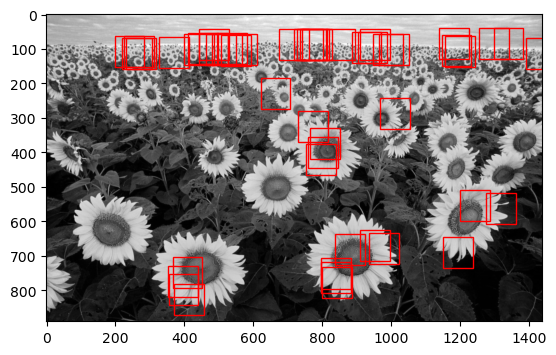

In [43]:
# Do the same but keeping 50 points

# Get the local maximal pixels for the correlation

# The values of the correlation go between 0 and 2778.  I'll take half of the max as being my threshold

thresh = 0.5

# Finds all of the local maximums in the correlation at the threshold (0.5 * max(corr))
# Keeping just the 10 highest peak intensities
xy_coords = ski.feature.peak_local_max(image=corr, min_distance=5, threshold_rel=thresh, num_peaks=50)

# Plotting
fig, ax = plt.subplots()
ax.imshow(gray_flowers_scaled, cmap='gray')

# For each of the xy_coords from the 2D correlation
for r in range(xy_coords.shape[0]):
    # Print the coords
    print(f'[{xy_coords[r][0]}] [{xy_coords[r][1]}]')
    y_offset = xy_coords[r][0] - (gray_template_scaled.shape[0]/2) # move the anchor (xy) to half the template away
    x_offset = xy_coords[r][1] - (gray_template_scaled.shape[1]/2) # move the anchor (xy) to half the template away

    rect = Rectangle((x_offset,y_offset), gray_template_scaled.shape[0], gray_template_scaled.shape[1], linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.show()

We see that with the scaled up image and the scaled down template, the template is trying to match more of the distance background sunflowers.  I believe this is happening as the background flowers are the ones that best match the template.